In [81]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import utils


# from ctapipe.io import read_table
# from astropy.table import vstack, Table
# # from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
# # from lstchain.io.io import dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_tel_mon_flat_key
# import matplotlib.pyplot as plt
# import numpy as np

# from ctapipe.visualization import CameraDisplay
# from ctapipe.coordinates import EngineeringCameraFrame
# from ctapipe.instrument import SubarrayDescription
# from ctapipe.containers import EventType

from ctapipe.io import read_table
from astropy.coordinates import SkyCoord
from traitlets.config.loader import Config
from lstchain.io.config import get_standard_config

# Some configurations

In [2]:
# Source specifications
source_name = "crab"

# Maybe we add a way to extract the run numbers we are interested in
run_numbers = [6172, 6242, 6194, 6875, 6892, 6893]


# Paths to data and results

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/lst_pipeline/"
# Path to store the configuration file we are going to use
config_file = root + "objects/standard_config.json"
# Data main directory
root_data = root + f"../../data/tests/{source_name}/"

# STANDARD paths ---------
# DL1 data root
dl1_root = "/fefs/aswg/data/real/DL1/*/v*/tailcut84/"
# RFs root main directory
rfs_root = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
# MCs dl2 main directory
mcs_root = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"


# Creating the directories in case they don't exist
for path in [config_file, root_data + "dl1b/", root_data + "dl2/", root_data + "dl3/", root_data + "irfs/"]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Opening and storing configuration file

In [4]:
config_dict = get_standard_config()
# print(config_dict)

#-------------------
# Changes in the configuration should be done here

# We select the heuristic flatfield option in the standard configuration
config_dict["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

#-------------------

with open(config_file, 'w') as json_file:
    json.dump(config_dict, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [5]:
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
},

# We create a empty dictionary to store all the information needed inside
DICT = {}
for run in run_numbers:
    DICT[run] = {
        "run_num" : run,
        "errors"  : "", # log of errors trough the analysis
    }

DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root)
DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root, dchecking=True)


Adding dl1  data to dictionary...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
...Finished adding dl1 data to dictionary


#### Then we read the observations information and we add it to the DICT

In [121]:
%%time
for run in run_numbers:

    tab = read_table(DICT[run]["dchecks"]["runwise"], "/dl1datacheck/cosmics")
    
    # reading the variables
    zd = 90 - np.rad2deg(np.array(tab["mean_alt_tel"]))
    az = np.rad2deg(np.array(tab["mean_az_tel"]))
    t_start   = tab["dragon_time"][0][0]
    t_elapsed = np.array(tab["elapsed_time"])
    
    DICT[run]["time"] = {
        "tstart"   : t_start,            # datetime object
        "telapsed" : np.sum(t_elapsed),  # s
        "srunwise" : {
            "telapsed" : t_elapsed,      # s      
        },
    }
    DICT[run]["pointing"] = {
        "zd" : np.mean(zd),  # deg
        "az" : np.mean(az),  # deg
        "srunwise" : {
            "zd" : zd,       # deg
            "az" : az,       # deg
        },
    }

CPU times: user 751 ms, sys: 285 ms, total: 1.04 s
Wall time: 1.03 s


In [127]:
# finding the RF nodes in DEC
rfs_decs = os.listdir(rfs_root)
rf_nodes_dec = [float(d.split("_")[-1][:-2] + "." + d.split("_")[-1][-2:]) for d in rfs_decs]

In [139]:
# and the MC nodes in AZ ZD
mcs_decs = os.listdir(mcs_root)
mc_nodes_dec = [float(d.split("_")[-1][:-2] + "." + d.split("_")[-1][-2:]) for d in mcs_decs]

for i, dec in enumerate(mcs_decs):
    nodes = os.listdir(mcs_root + dec)
    zds = [float(n.split("_")[2]) for n in nodes]
    azs = [float(n.split("_")[4]) for n in nodes]

In [140]:
zds

[73.142,
 70.732,
 43.113,
 43.197,
 68.068,
 52.374,
 60.528,
 60.66,
 52.374,
 52.374,
 14.984,
 37.814,
 43.197,
 57.995,
 43.197,
 10.0,
 35.904,
 69.512,
 68.068,
 67.045,
 75.226,
 55.25,
 60.528,
 60.528,
 74.336,
 70.732,
 65.976,
 32.059,
 63.255,
 65.976,
 65.796,
 23.63,
 60.528,
 43.197,
 52.374,
 60.528,
 75.226,
 39.646,
 57.995,
 52.41,
 55.944,
 75.226,
 32.059,
 75.226,
 75.226,
 75.522,
 60.528,
 82.155,
 52.374,
 55.25,
 10.0,
 60.528,
 59.336,
 61.965,
 47.952,
 46.37,
 49.458,
 43.197,
 68.068,
 52.374,
 14.984,
 52.41,
 68.068,
 32.059,
 68.284,
 55.944,
 43.197,
 35.904,
 32.059,
 49.458,
 73.142,
 64.533,
 37.814,
 75.522,
 39.646,
 56.633,
 61.965,
 75.226,
 68.068,
 43.197,
 63.255,
 82.155,
 67.045,
 56.633,
 43.113,
 23.63,
 64.533,
 32.059,
 68.284,
 46.37,
 71.94,
 69.512,
 59.336,
 52.374,
 75.226,
 74.336,
 52.374,
 65.796,
 68.068,
 60.66,
 68.068,
 52.374,
 47.952,
 71.94,
 32.059]

In [128]:
rf_nodes

[9.31, 34.76, 66.76, 4.13, 22.76, 48.22]

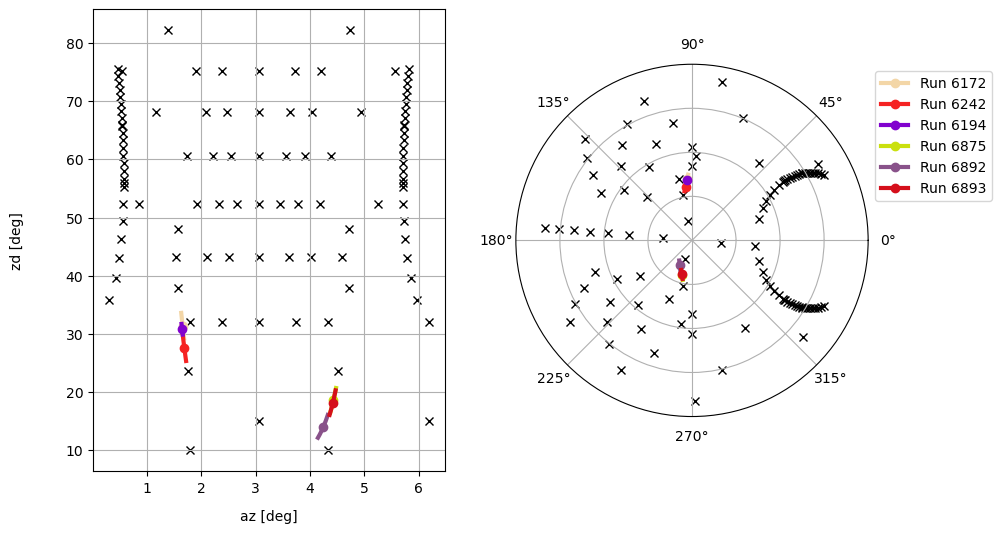

In [188]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

for run in run_numbers:
    color = np.random.rand(3) # random color for each run
    for ax, marker in [ax1, ax2]:
        ax.plot(np.deg2rad(DICT[run]["pointing"]["srunwise"]["az"]), DICT[run]["pointing"]["srunwise"]["zd"], marker="",  color=color, ls="-", lw=3)
        ax.plot(np.deg2rad(DICT[run]["pointing"]["az"]),             DICT[run]["pointing"]["zd"],             marker="o", color=color, ls="",  ms=6)
        ax.plot([], [], marker="o", ls="-", lw=3, color=color, label=f"Run {run}")

for ax in [ax1, ax2]:
    ax.plot(np.deg2rad(azs), zds, marker="x", ls="", color="k", zorder=-10)   
    ax.grid(True)

ax2.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax2.set_yticklabels([])
ax2.set_yticks([22.5, 45, 67.5])
ax2.set_ylim(0, 90)
ax1.set_xlabel("az [deg]", labelpad=10)
ax1.set_ylabel("zd [deg]", labelpad=30)
plt.show()

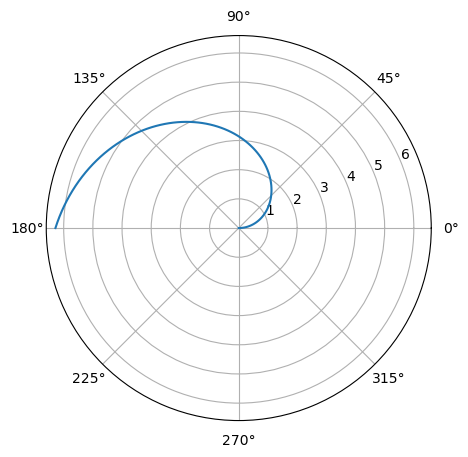

In [169]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})

x = np.deg2rad(np.linspace(0, 180, 100))
y = np.deg2rad(np.linspace(0, 360, 100))
plt.plot(x,y)
plt.show()

In [68]:
total_t_elapsed/60

20.099662776788076

In [62]:
timestamp

1644015343.2623787

In [12]:
import pandas as pd
import h5py

In [15]:
a = h5py.File(DICT[6875]["dchecks"]["runwise"])

In [25]:
b = a["dl1datacheck/cosmics"]

In [31]:
b.fields

<bound method Dataset.fields of <HDF5 dataset "cosmics": shape (172,), type "|V668440">>

#### First the RFs we need to use for the source

#### Then the MC dl2 files associated to our observations

In [ ]:
DICT[6875]

In [ ]:
# source_ra  = f"{source_coords.ra.deg}deg"
# source_dec = f"{source_coords.dec.deg}deg"

In [ ]:
k = "source_config"
kk = "LSTEventSource"
for kkk in config[k][kk].keys():
    try:
        print(kkk, config[k][kk][kkk] == dictionary[k][kk][kkk])
    except:
        print(kkk, "ERRRO")

In [ ]:
k, kk, config[k][kk]

In [ ]:



# Reading the configuration file
config = Config(read_configuration_file(config_file))
config

In [ ]:
!lstchain_dl1ab -h

In [ ]:
test_dl1 = "test_data/dl1_LST-1.Run02977.0122.h5"
config_file = "/fefs/aswg/lstosa/config_files_lstchain/lstchain_standard_v0.10_heuristic_ff.json"
newname  = "test_data/dl1_LST-1.Run02977.0122_ls0.9.h5"

!lstchain_dl1ab \
    -f $test_dl1 \
    -o $newname \
    -c $config_file \
    --light-scaling 0.9 \

In [ ]:
subarray_info = SubarrayDescription.from_hdf(test_dl1)
camgeom = subarray_info.tel[1].camera.geometry

# Read parameters table from file:
dl1_parameters = read_table(test_dl1, dl1_params_lstcam_key)
dl1_parameters_b = read_table(newname, dl1_params_lstcam_key)
dl1_parameters.columns

In [ ]:
plt.hist2d(np.log10(dl1_parameters['intensity'][cosmics & valid_image]), np.log10(dl1_parameters_b['intensity'][cosmics & valid_image]), 200);

In [ ]:
cosmics = dl1_parameters['event_type'] == EventType.SUBARRAY.value
pedestals = dl1_parameters['event_type'] == EventType.SKY_PEDESTAL.value
flatfield = dl1_parameters['event_type'] == EventType.FLATFIELD.value

print('Cosmics (showers):', np.sum(cosmics))
print('Interleaved pedestals:', np.sum(pedestals))
print('Interleaved flatfield:', np.sum(flatfield))

In [ ]:
valid_image = dl1_parameters['intensity'] > 0 # Image survived image and was parametrized
print("Events which survived cleaning:")
print('Cosmics (showers):', np.sum(cosmics & valid_image))
print('Interleaved pedestals:', np.sum(pedestals & valid_image))
print('Interleaved flatfield:', np.sum(flatfield & valid_image))

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(np.log10(dl1_parameters['intensity'][cosmics & valid_image]), 
         bins=120, range=(1, 7), histtype='step', log=True, label='cosmics')
plt.hist(np.log10(dl1_parameters['intensity'][flatfield & valid_image]), 
         bins=120, range=(1, 7), histtype='step', log=True, label='flatfield')
plt.hist(np.log10(dl1_parameters['intensity'][pedestals & valid_image]), 
         bins=120, range=(1, 7), histtype='step', log=True, label='pedestals')
plt.legend()
plt.xlabel('log10(Intensity/p.e.)')
plt.ylabel('events')
plt.show()

In [ ]:
dl1_images = read_table(test_dl1, dl1_images_lstcam_key)

# Locate first table entry for which n_pixels (after cleaning) is larger than 100, 
# is more or less centered (c.o.g. within 0.5 m of the camera center), and is a cosmic (="SUBARRAY"):
mask = ((dl1_parameters['intensity'] > 1000) &
        (dl1_parameters['n_pixels']>200) & 
        (dl1_parameters['r']<0.5*u.m) &
        (dl1_parameters['event_type']==EventType.SUBARRAY.value)
       )

index = np.where(mask)[0][0]

In [ ]:
plt.figure(figsize=(10,8))
camdisplay = CameraDisplay(camgeom, dl1_images['image'][index])
camdisplay.add_colorbar()
plt.show()